# set-up

## Imports

In [63]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings

# session lists in a .py file
# import sessionlists
%run sessionlists
import VIGOR_dataProcessing 
import VIGOR_WAITMODEL_Functions

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code
%run VIGOR_Functions
plt.style.use('./Figures/test.mplstyle')

<Figure size 432x288 with 0 Axes>

## Define data path.

In [64]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/DATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1oxWJLF67TEifzQFgtUHIyhnEsS6AeQUW
    !unzip -qq /content/code/datacopy.zip
    root="/content/code/datacopy"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)


Path to data is: /home/david/Desktop/DATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save


## Load processed data

In [65]:
rat_markers = {}
sequence = {}

# define colors for each rat
palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2), 'RatF03': (1, 0.6, 0.6),
            'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2), 'RatM03': (0.6, 1.0, 0.6)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'lesion', 'RatF02': 'normal', 'RatF03': 'lesion',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal', 'RatM03': 'normal'}

# define list of rats to be analyzed
# only these rats will be loaded and analyzed for now   
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02']  # [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'): rat_markers[animal]=[palette[animal], "$\u2640$", brainstatus_plot(brainstatus[animal])]
    elif fnmatch.fnmatch(animal, 'RatM*'): rat_markers[animal]=[palette[animal], "$\u2642$", brainstatus_plot(brainstatus[animal])]
    elif fnmatch.fnmatch(animal, 'Rat00*'): rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$", brainstatus_plot(brainstatus[animal])]
    else: print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + \
                                                TM20+TM10+TM2+TMrev2+TMrev10+TMrev20+\
                                                dist60bis+dist90bis+dist120bis)):
        # get the preprocessed data from the pickle file
        # In this notebook we only need the sequence of events, so we only load that
        sequence[animal, session] = get_from_pickle(root, animal, session, name="test.p")




Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02


In [66]:
def get_running_times(data, memsize=3, filter=[0, 3600], tooshort=0.5):
    """get waiting times from data"""
    running_times = {k:[] for k in meankeys(generate_targetList(seq_len=memsize)[::-1])}
    for i in range(len(data)):
        if data[i][1] == 'run':
            if filter[0] <= data[i][0] <= filter[1] and data[i][3] != 0:
                if data[i][3] > tooshort:  # filter out waits shorter than 0.5s
                    try:
                        avg_rwd = round(np.mean([data[i-n-1][2] for n in range(1, (memsize*2)+1, 2)]),2)
                        running_times[avg_rwd].append(data[i][3])
                    except:  # put the first n waits in rwd=1 (because we don't have the previous n runs to compute the average reward)
                        running_times[1].append(data[i][3])
    return running_times

# separate the data into time and reward bins
def prepare_dataR(sequence, animalList, sessionList, memsize=3, time_bins=6):
    bin_size = 3600/time_bins
    targetlist = generate_targetList(memsize)[::-1]
    temp_data = {}
    for bin in range(time_bins):
        temp_data[bin] = {}
        for animal in animalList:
            temp_data[bin][animal] = {k:[] for k in meankeys(targetlist)}
            for session in matchsession(animal, sessionList):
                temp_data[bin][animal] = combine_dict(temp_data[bin][animal], get_running_times(sequence[animal, session], memsize=memsize, filter=[bin*bin_size, (bin+1)*bin_size]))
    
    data = {}
    for animal in animalList:
        data[animal] = np.zeros((time_bins, len(meankeys(targetlist)))).tolist()
        for i, avg in enumerate(meankeys(targetlist)):  # 1 -> 0
            for bin in range(time_bins):
                data[animal][bin][i] = np.asarray(temp_data[bin][animal][avg])
    return data


data60 = prepare_dataR(sequence, animalList, dist60)
data90 = prepare_dataR(sequence, animalList, dist90)
data120 = prepare_dataR(sequence, animalList, dist120)

data20 = prepare_dataR(sequence, animalList, TM20)
data10 = prepare_dataR(sequence, animalList, TM10)
data2 = prepare_dataR(sequence, animalList, TM2+TMrev2)
datarev10 = prepare_dataR(sequence, animalList, TMrev10)
datarev20 = prepare_dataR(sequence, animalList, TMrev20)

In [67]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings

# session lists in a .py file
# import sessionlists
%run sessionlists
import VIGOR_dataProcessing 
import VIGOR_WAITMODEL_Functions

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code
%run VIGOR_Functions
plt.style.use('./Figures/test.mplstyle')

## Define data path.

In [68]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/DATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1oxWJLF67TEifzQFgtUHIyhnEsS6AeQUW
    !unzip -qq /content/code/datacopy.zip
    root="/content/code/datacopy"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)


Path to data is: /home/david/Desktop/DATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save


# Introduction

## Task  
The task and the main behavioral results are presented in notebook 1.  
We developed an automated foraging task in which water restricted rats have to run back and
forth on a treadmill to obtain drops of water. Within one hour-long session, the
probability of getting a reward was alternatively high and low in 5 min-long uncued
blocks (dark and light gray in fig.1).  

<img src="Figures/Picturetask1.png" alt="task" width="300"/>  

## Experimental conditions
Across sessions, we manipulated the effort rats had to produce by either
modifying the length of the treadmill while its speed remained null, or by
manipulating the speed and direction of the belt to facilitate or counteract the
animals' crossings.

<img src="Figures/conditions.png" alt="conditions" width="600"/>

# Aim of the Notebook 
One of the variables that we analyze is the duration of the running times (blue part on the track of the animal, Fig 1A.).  
A quick analysis of the median running time shows that it increases along the 
session, but no clear modulation in function of reward (Fig1B.); i.e. animals are less motivated/more tired as time passes, they run slower and don't modulate their speed according to the reward probability.   

In this notebook we characterise how time and reward probability affects running time.  

Fig 1.  
A) Position of an example animal across a 120 cm session. Blue is run epoch, orange is running epoch.  
Reward probability in 5 min blocks is either high (90%, dark gray), or low (10%, light gray)  
B) Median running time across session and blocks.  
Reward probability in 5 min blocks is either high (90%, dark gray), or low (10%, light gray)  

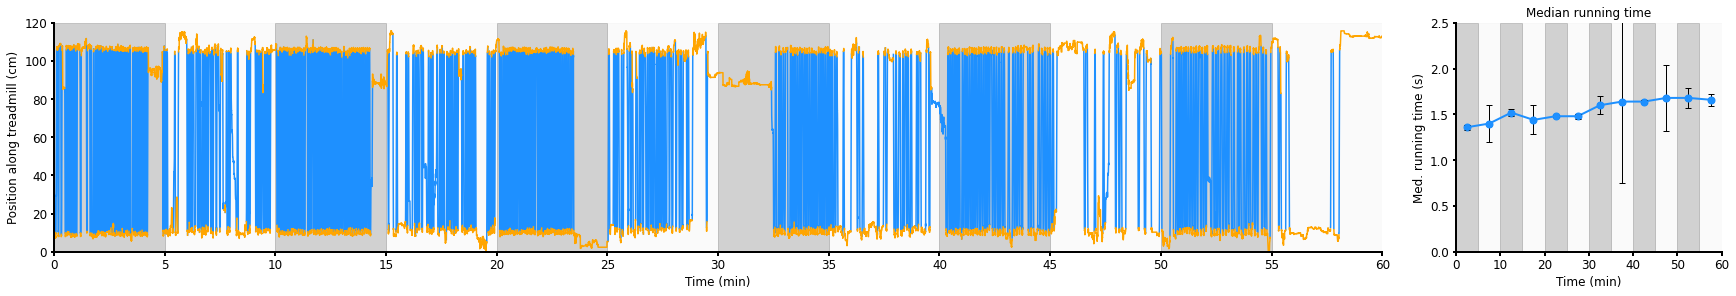

In [69]:
# Fig 1.
animal, session = 'RatM01', 'RatM01_2021_07_22_17_14_48'  # 'RatF00', 'RatF00_2021_07_24_15_28_05'
fig, axs = plt.subplots(1, 2, figsize = (24, 4), gridspec_kw={'width_ratios': [5, 1]})

# Load preprocessed data for one animal and one session. params contains the parameters of the session,
# runningTimeInLeftBin and runningTimeInRightBin contain the running time in each time bin for each animal
example_params = get_from_pickle(root, animal, session, name="params.p")
example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")

# plot the trajectory
plot_animal_trajectory(root=root, animal=animal, session=session, params=example_params, barplotaxes=[0, 3600, 0, 120], 
                 xyLabels=["Time (min)", "Position along treadmill (cm)"], title="Position of example animal across a 120 cm session", ax=axs[0])

# plot the median running time in each time block
plot_median_per_bin([example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)], 
                example_params['rewardProbaBlock'], example_params['blocks'], barplotaxes=[0, 3600/60, 0, 2.5], 
                color=['dodgerblue'], xyLabels=["Time (min)","running time (s)"], title="Median running time", scatter=False, stat='Med. ', ax=axs[1]);

# Data binning

The data is binned as in the running time model. 
This yields the following complete distribution.

In [70]:
from scipy.stats import cauchy

In [71]:
def plot_full_distributionRun(data, animal, plot_fit=False, N_bins=6, N_avg=4):
    '''plot the full distribution of the data'''
    ###
    # NOT SAME NUMBER OF OBSERVATIONS IN EACH CURVE, BUT SAME NORMALIZATION ???
    ###

    def _plot_Cauchy_fitted(waits, p, ax=None, color='k', plot_fit=True, label='', lw=2):
        """plot fitted wald distribution without fitting"""
        if ax is None:
            ax = plt.gca()
        waits = np.asarray(waits)

        bins = np.linspace(0, waits.max(), int(max(waits))*25)
        ydata, xdata, _ = ax.hist(waits, bins=bins,
                                  color=color, alpha=1, zorder=1,
                                  density=True,  # weights=np.ones_like(waits) / len(waits),
                                  histtype="step", lw=lw, cumulative=-1, label=label)

        if plot_fit:
            x = np.linspace(0.001, 500, 10000)
            loc, scale = p
            ax.plot(x, cauchy.sf(x, loc=loc, scale=scale), color=color, lw=2, zorder=4, ls='--', label=f'{label} fit')
        return ax


    fig, axs = plt.subplots(1, N_bins, figsize=(3*N_bins, 3))
    (mu, sigma, mu_t, sigma_t, mu_R, sigma_R), loss = modelrun_fit(data[animal])

    lbls = ['1', '0.67', '0.33', '0']
    for j in range(N_bins):
        for i in range(N_avg):
            color = plt.get_cmap('inferno')(i / N_avg)
            lw = 3.5 if j == 0 and i == 1 else 2
            _plot_Cauchy_fitted(data[animal][j][i],
                              (mu + j*mu_t + i*mu_R,
                               sigma + j*sigma_t + i*sigma_R), 
                              ax=axs[j], color=color, plot_fit=plot_fit, label=lbls[i], lw=lw)
        axs[j].set_xlim(.1, 100)
        axs[j].set_ylim(.001, 1.1)
        axs[j].set_xscale("log")
        axs[j].set_yscale("log")
        axs[j].set_xlabel('log(idle time) (s)')
        axs[j].set_ylabel('log(1-CDF)')
        axs[j].set_title(f'{j*10}-{(j+1)*10} min')
        axs[j].legend()

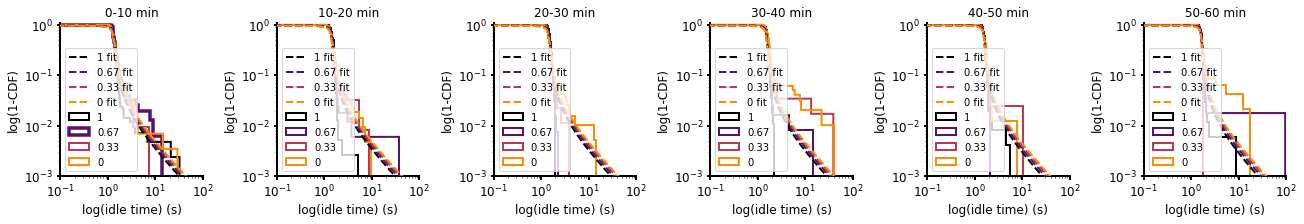

In [72]:
# Fig 3.
# distribution of running times

animal = 'RatM01'
exampledata = prepare_dataR(sequence, animalList, dist120)
plot_full_distributionRun(exampledata, animal, plot_fit=True)

# Distributions

Text(0, 0.5, 'CDF')

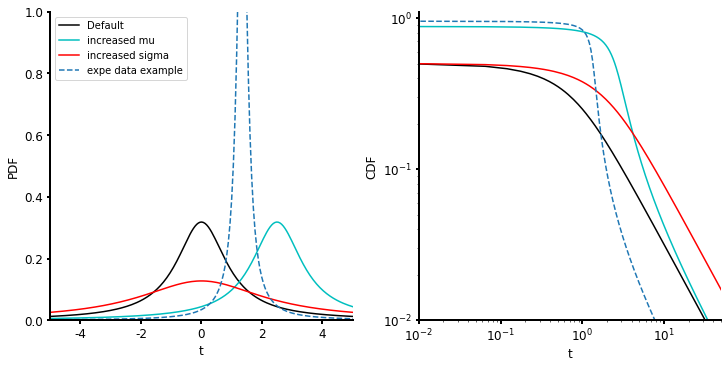

In [73]:
from scipy.stats import cauchy
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
x = np.linspace(-5, 50, 1000)
axs[0].plot(x, cauchy.pdf(x, 0, 1), 'k-', label='Default')
axs[0].plot(x, cauchy.pdf(x, 2.5, 1), 'c', label='increased mu')
axs[0].plot(x, cauchy.pdf(x, 0, 2.5), 'r-', label='increased sigma')
axs[0].plot(x, cauchy.pdf(x, 1.35, .2), '--', label='expe data example')
axs[0].set_ylabel('PDF')
axs[0].set_xlabel('t')
axs[0].set_xlim(-5, 5)
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].plot(x, cauchy.sf(x, 0, 1), 'k-', label='Default')
axs[1].plot(x, cauchy.sf(x, 2.5, 1), 'c', label='increased mu')
axs[1].plot(x, cauchy.sf(x, 0, 2.5), 'r-', label='increased sigma')
axs[1].plot(x, cauchy.sf(x, 1.35, .2), '--', label='expe data example')
axs[1].set_xlabel('t')
axs[1].set_xlim(0.01, 50)
axs[1].set_ylim(0.01, 1.1)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_ylabel('CDF')

## Fitting
We fit running time distributions $x$ to the Cauchy distribution using the maximum likelihood estimation method.

We find the parameters $\hat{\mu}, \hat{\sigma}$ that maximizes the log-likelihood function $\ell (Cauchy(x); \mu, \sigma)$, with $\mu, \sigma \in \Mu, \Sigma$, using the default 'L-BFGS-B' method from scipy. https://en.wikipedia.org/wiki/Limited-memory_BFGS#L-BFGS-B  
 
Fig 5.
Sanity check: We generate synthetic running times from a Wald distribution with known $\mu, \sigma$ parameters, and fit them to check that the fitted parameters are the same as the known parameters. We are able to recover the parameters well (QUANTIFY).  

TOP LEFT) Synthetic data fit with different values of $\sigma$.  
TOP RIGHT) Synthetic data fit with different values of $\mu$  
BOT LEFT&RIGHT) Hidden (lines) and recovered (dots) parameters

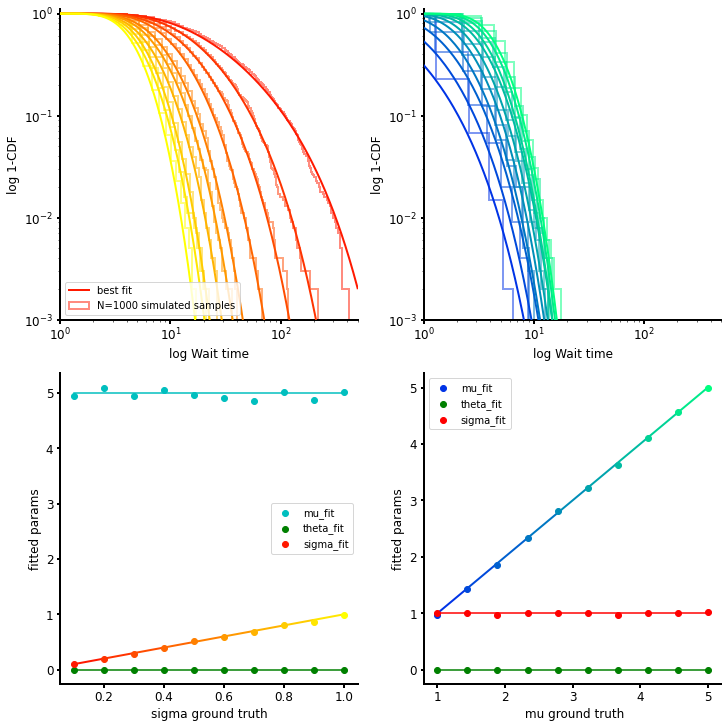

In [74]:
# redo
t0 = 0
N = 1000
std = 1
AAA = 5
MEAN = 1

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

means = np.linspace(0.1, 1, 10)
plot_color_line(axs[1, 0], means, means, means, cmap = 'autumn', vmin=0, vmax=1, alpha=1, linewidth=2, linestyle = '-', zorder = 1)
axs[1, 0].plot(means, [t0 for _ in means], color='g')
axs[1, 0].plot(means, [AAA for _ in means], color='c')
for mean in means:
    mu, theta, sigma, lossWald = example_wald_fit(mean, std, AAA, t0, N, ax=axs[0, 0], color=plt.get_cmap('autumn')(mean / max(means)))
    axs[1, 0].scatter(mean, mu, color='c', label='mu_fit')
    axs[1, 0].scatter(mean, theta, color='g', label='theta_fit')
    axs[1, 0].scatter(mean, sigma, color=plt.get_cmap('autumn')(mean / max(means)), label='sigma_fit')
    axs[1, 0].set_xlabel('sigma ground truth')
    axs[1, 0].set_ylabel('fitted params')

As = np.linspace(1, 5, 10)
plot_color_line(axs[1, 1], As, As, As, cmap = 'winter', vmin=0, vmax=5, alpha=1, linewidth=2, linestyle = '-', zorder = 1)
axs[1, 1].plot(As, [t0 for _ in As], color='g')
axs[1, 1].plot(As, [MEAN for _ in As], color='r')
for A in As:
    mu, theta, sigma, lossWald = example_wald_fit(MEAN, std, A, t0, N, ax=axs[0, 1], color=plt.get_cmap('winter')(A / max(As)))
    axs[1, 1].scatter(A, mu, color=plt.get_cmap('winter')(A / max(As)), label='mu_fit')
    axs[1, 1].scatter(A, theta, color='g', label='theta_fit')
    axs[1, 1].scatter(A, sigma, color='r', label='sigma_fit')
    axs[1, 1].set_xlabel(' mu ground truth')
    axs[1, 1].set_ylabel('fitted params')


legend_without_duplicate_labels(axs[1, 0])
legend_without_duplicate_labels(axs[1, 1])

# Running time model


We have the Cauchy distribution with $\mu$ and $\sigma$ parameters that we can fit and recover from individual running times distributions. 
We've seen earlier that the sub-distributions of running times in our data changes with time $t$ but not with the reward history $R$.  
Can we link $t$ and $R$ to $\mu$ and/or $\sigma$?  

To evaluate how $\mu$ and $\sigma$ change with $t$ and/or $R$ we define the following model:

$\Mu(t, R) = \mu_0 + \mu_t t + \mu_R R$  
$\Sigma(t, R) = \sigma_0 + \sigma_t t + \sigma_R R$  

With:  
$\mu_0, \sigma_0$ parameters at the beginning of the session (0-10 min) and $\frac{3}{3}$ rewards have been obtained  
$\mu_t, \sigma_t$ how $\mu$ and $\sigma$ evolve linearly with time  
$\mu_R, \sigma_R$ how $\mu$ and $\sigma$ evolve linearly with reward history  


We find the best $\mu_0, \mu_t, \mu_R, \sigma_0, \sigma_t, \sigma_R$ that minimize the total error of the model using maximum likelihood estimation.  

The total error of the model is defined as:  
$\sum_{n_t=0}^{6} \sum_{n_R=0}^{1} \frac{\ell (Wald(x(t, R)); \mu_0 + \mu_t + \mu_R, \sigma_0 + \sigma_t + \sigma_R)}{N(t, R)}$  

with:  
$x$, experimental data  
$x(t, R)$, experimental data for a given $t$ and $R$  
$N(t, R)$, number of observations in $x(t, R)$


## Graphical representation of $\mu$ and $\sigma$ evolution
Evolution of $\mathrm{A}$ and $\sigma$ on the z axis, with $R$ on the x axis, $t$ on the y axis.  
- $\Mu$: starts low, increases with $t$, no change with $R$  
- $\sigma$: 

In [75]:
# ok
from scipy.stats import cauchy
def modelrun_crit(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg] if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            pdf_vals = cauchy.pdf(args[0][bin][avg], scale=_sigma, loc=_mu,)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            neg_log_lik_val += (-log_lik_val / n)
            # except:
            #     neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val

def modelrun_compare(params, *args, robustness_param=1e-20):
    """BIC to compare models with different number of parameters and curves"""
    mu, sigma, mu_t, sigma_t, mu_R, sigma_R = params
    BIC = 0
    N_bins, N_avg = args[1]
    N_params = args[2]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_t + avg*mu_R
            SIGMA[bin, avg] = sigma + bin*sigma_t + avg*sigma_R

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg] if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8
            # try:
            pdf_vals = cauchy.pdf(args[0][bin][avg], loc=_mu, scale=_sigma)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            k = N_params
            BIC += k * np.log(n) - 2 * log_lik_val
            # except:
            #     BIC += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return BIC

#params = a, t, g, a', t', g', a'', t'', g''
def modelrun_fit(data, init=[1, 1, 1, 1, 1, 1], f=modelrun_crit, 
N_bins=6, N_avg=4, N_params=2, mu_t_fixed=False, sigma_t_fixed=False, mu_R_fixed=False, sigma_R_fixed=False, ):
    params_init = np.array(init)
    mu_t_bounds = (None, None) if not mu_t_fixed else (0, 1e-8)
    sigma_t_bounds = (None, None) if not sigma_t_fixed else (0, 1e-8)
    mu_R_bounds = (None, None) if not mu_R_fixed else (0, 1e-8)
    sigma_R_bounds = (None, None) if not sigma_R_fixed else (0, 1e-8)

    res = scipy.optimize.minimize(f, params_init, args=(data, [N_bins, N_avg], N_params), 
                                        bounds=((0, None), (0, None), 
                                            mu_t_bounds, sigma_t_bounds, 
                                            mu_R_bounds, sigma_R_bounds))
    return res.x, res.fun

modelrun_fit(data60[animal])
modelrun_fit(data60[animal], f=modelrun_compare)

(array([0.80608909, 0.06225699, 0.05530117, 0.0109821 , 0.00233962,
        0.01196265]),
 -1796.0745647262572)

RatF01  mu:1.39, mut:0.06, muR: 0.00, || s: 0.09, st: 0.01, sR: 0.04 ||| loss: 14.91


/home/david/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:137: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


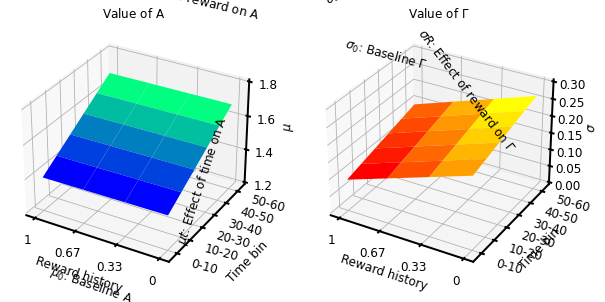

In [76]:
# NOT THE SAME ANIMAL AS BEFORE (RatM01)!!!!!!!!

def plot_parameter_evolutionRunTime(p, axs=None, N_bins=6, N_avg=4):

    (mu, sigma, mu_t, sigma_t, mu_R, sigma_R) = p
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_t + avg*mu_R
            SIGMA[bin, avg] = sigma + bin*sigma_t + avg*sigma_R

    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

    X, Y = np.meshgrid(np.arange(N_avg), np.arange(N_bins))
    axs[0].plot_surface(X, Y, MU, cmap='winter', edgecolor='none')
    axs[0].set_title(r'Value of $\mathrm{A}$')
    axs[0].set_xticks([0, 1, 2, 3])
    axs[0].set_xticklabels(['1', '0.67', '0.33', '0'])
    axs[0].set_xlabel('Reward history', labelpad=5)
    axs[0].set_ylim([-0.5, 5.5])
    axs[0].set_yticks([0, 1, 2, 3, 4, 5])
    axs[0].set_yticklabels(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60'], va='center', ha='left', rotation=-15)
    axs[0].set_ylabel('Time bin', labelpad=15)
    axs[0].set_zlabel(r'$\mu$', labelpad=5)
    axs[0].set_zlim([1.2, 1.8])
    axs[0].set_zticks([1.2, 1.4, 1.6, 1.8])
    # axs[0].set_zticklabels(['1.0', '1.5', '2.0'])
    axs[0].text(0., 5, 2., r"$\mu R$: Effect of reward on $\mathrm{A}$", color='black', fontsize=12, zdir='x', zorder=10)
    axs[0].text(3, 0.5, 1.2, r"$\mu t$: Effect of time on $\mathrm{A}$", color='black', fontsize=12, zdir=(0, 6, 1), zorder=10)
    axs[0].text(0, 0, 0.6, r"$\mu_0$: Baseline $\mathrm{A}$", color='black', fontsize=12, zdir='x', zorder=10)

    axs[1].plot_surface(X, Y, SIGMA, cmap='autumn', edgecolor='none')
    axs[1].set_title(r'Value of $\Gamma$')
    axs[1].set_xticks([0, 1, 2, 3])
    axs[1].set_xticklabels(['1', '0.67', '0.33', '0'])
    axs[1].set_xlabel('Reward history')
    axs[1].set_ylim([-0.5, 5.5])
    axs[1].set_yticks([0, 1, 2, 3, 4, 5])
    axs[1].set_yticklabels(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60'], va='center', ha='left', rotation=-15)
    axs[1].set_ylabel('Time bin')
    axs[1].set_zlabel(r'$\sigma$')
    axs[1].set_zlim([.0, .3])
    # axs[1].set_zticks([.2, .4, .6, 0.8])
    # axs[1].set_zticklabels(['0.2', '0.4', '0.6', '0.8'])
    axs[1].text(0, 5, 0, r"$\sigma R$: Effect of reward on $\Gamma$", color='black', fontsize=12, zdir=(4, 0, -.5), zorder=10)
    axs[1].text(0, -1, .6, r"$\sigma t$: Effect of time on $\Gamma$", color='black', fontsize=12, zdir=(0, -10, .1), zorder=10)
    axs[1].text(0, 0, 0.4, r"$\sigma_0$: Baseline $\Gamma$", color='black', fontsize=12, zdir='x', zorder=10)

# example fit model on all 120 cm session for each animal
# print fitted parameters and loss for each animal
animal = 'RatF01'
exampledata = prepare_dataR(sequence, animalList, dist120)
p, loss = modelrun_fit(exampledata[animal])
(mu, sigma, mu_t, sigma_t, mu_R, sigma_R) = p

print(f"{animal}  mu:{mu:.2f}, mut:{mu_t:.2f}, muR: {mu_R:.2f}, || s: {sigma:.2f}, st: {sigma_t:.2f}, sR: {sigma_R:.2f} ||| loss: {loss:.2f}")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})
plot_parameter_evolutionRunTime((mu, sigma, mu_t, sigma_t, mu_R, sigma_R), axs=axs)

# Results
### Example animal fit - 120cm
Fit of the model for the same example animal on all Dist-120cm sessions.  

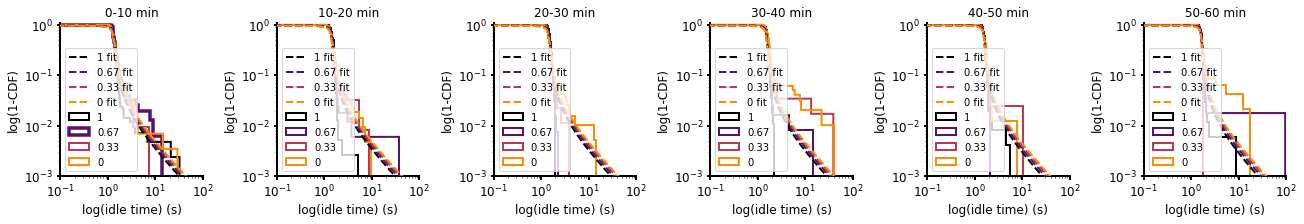

In [77]:
animal = 'RatM01'
exampledata = prepare_dataR(sequence, animalList, dist120)
plot_full_distributionRun(exampledata, animal, plot_fit=True)

### All experimental conditions fit
We can now do the same as above for all experimental conditions (Distances and TM speed) and for each rat.  
Each color is a different rat.  

$Mu$:  
- $\mu_0$ > 0, positive bound at start, increases with distance and when TM speed reverse  
- $\mu_t$ > 0, $\mu$ increases with time  
- $\mu_R$ = 0, no effect of reward history on $\mu$  

The average running time increases when distance increases, and when TM is reversed -> animals do not manage to keep up the pace. 
The average running time increases with time, but not with reward history.  
**$mu$ is congruent with *tiredness*, low at the start of session, increases with time/total distance traveled**


$\sigma$:  
- $\sigma_0$ > 0, initial variability  
- $\sigma t$ ~ 0, no effect of time on $\sigma$  
- $\sigma R$ > 0, $\sigma$ increases with reward history  

**Variability increases when no reward. *exploration/exploitation*?**  
 

**!!! Do stats !!!**

0 60 vs 90: 0.000 *
0 60 vs 120: 0.000 *
0 90 vs 120: 0.000 *
0 20 vs rev10: 0.041 *
0 20 vs rev20: 0.006 *
0 10 vs rev20: 0.031 *
0 2 vs rev20: 0.034 *


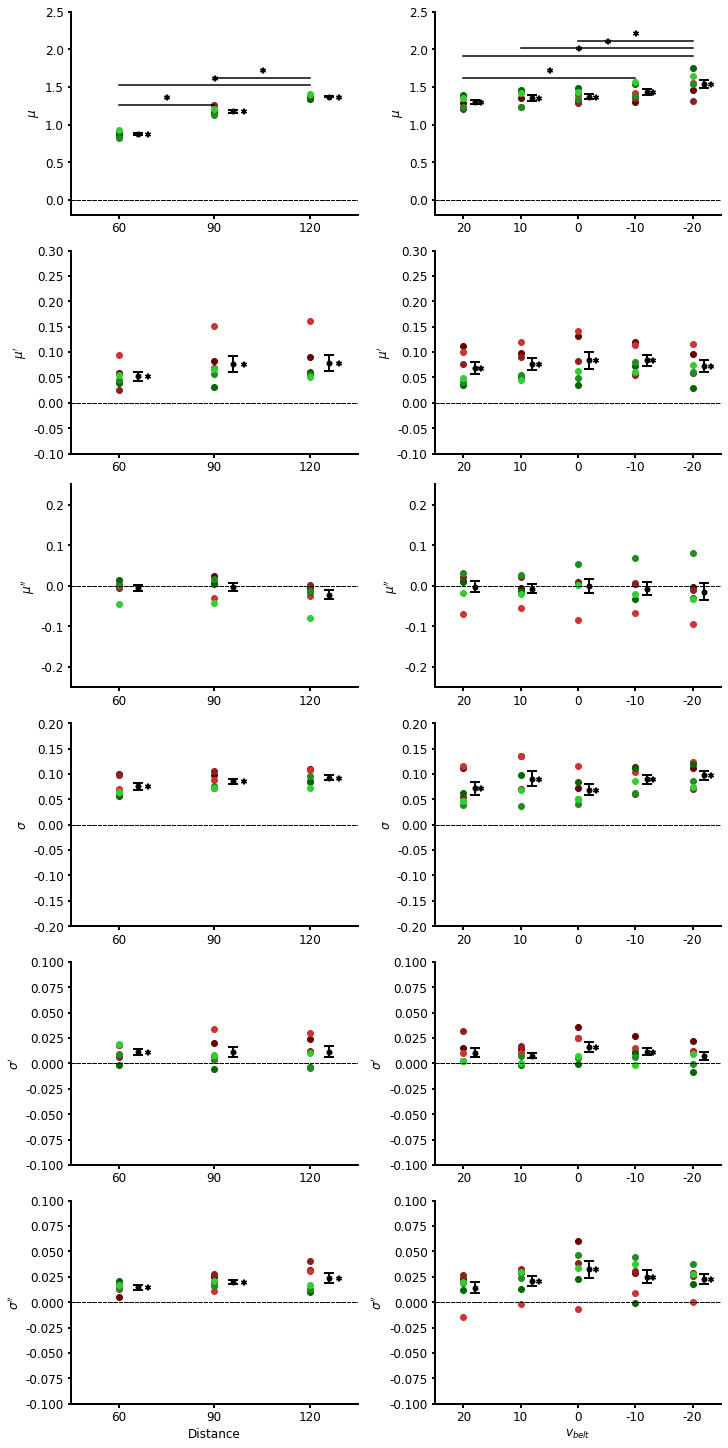

In [78]:
# ok
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
ylabels = [r'$\mu$', r"$\mu'$", r"$\mu''$", r'$\sigma$', r"$\sigma'$", r"$\sigma''$"]
# ylabels = [r'$\mu$', r"$\mu'/\mu$", r"$\mu''/\mu$", r'$\sigma$', r"$\sigma'/\sigma$", r"$\sigma''/\sigma$"]
ylims = [[-.2, 2.5], [-.1, .3], [-.25, .25], [-.2, .2], [-.1, .1], [-.1, .1], ]



mu = {}
sigma = {}
mu_t = {}
sigma_t = {}
mu_R = {}
sigma_R = {}
lossWald = {}

mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, False, False, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, True, True, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = False, False, True, False
# mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed = True, True, True, True

for animal in animalList:

    mu[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    mu_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    mu_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    sigma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
        (mu[animal][cond], sigma[animal][cond], \
        mu_t[animal][cond], sigma_t[animal][cond], \
        mu_R[animal][cond], sigma_R[animal][cond]), lossWald[animal][cond] = modelrun_fit(data[animal], mu_t_fixed=mu_t_fixed, 
                                                                                                                                    sigma_t_fixed=sigma_t_fixed, 
                                                                                                                                    mu_R_fixed=mu_R_fixed, 
                                                                                                                                    sigma_R_fixed=sigma_R_fixed, 
                                                                                                                                    )
        # ######### normalize p' and p'' by p
        # mu_t[animal][cond] /= mu[animal][cond]
        # sigma_t[animal][cond] /= sigma[animal][cond]
        # mu_R[animal][cond] /= mu[animal][cond]
        # sigma_R[animal][cond] /= sigma[animal][cond]
        # ###############

    vars = [mu, mu_t, mu_R, sigma, sigma_t, sigma_R, ]

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 0].scatter(np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]], color=rat_markers[animal][0], label=animal)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 1].scatter(np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], color=rat_markers[animal][0], label=animal)
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')

#mean per condition
for idx, cond in enumerate(["60", "90", "120"]):
    for jdx, var in enumerate([ mu, mu_t, mu_R, sigma, sigma_t, sigma_R,]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        s, p = stats.ttest_1samp(d, 0)
        if p < .05: axs[jdx, 0].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 0].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

for idx, cond in enumerate(["20", "10", "2", "rev10", "rev20"]):
    for jdx, var in enumerate([ mu, mu_t, mu_R, sigma, sigma_t, sigma_R,]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        s, p = stats.ttest_1samp(d, 0)
        if p < .05: axs[jdx, 1].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 1].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

test_all_conds_between_themselves(["60", "90", "120"], vars, ax=axs[:, 0])
test_all_conds_between_themselves(["20", "10", "2", "rev10", "rev20"], vars, ax=axs[:, 1])


RatF00   a: 1.37, a': 0.09, a'': -0.00, || g: 0.11, g': 0.02, g'': 0.03,||| loss: 20.65
RatF01   a: 1.39, a': 0.06, a'': 0.00, || g: 0.09, g': 0.01, g'': 0.04,||| loss: 14.91
RatF02   a: 1.34, a': 0.16, a'': -0.02, || g: 0.11, g': 0.03, g'': 0.03,||| loss: 23.25
RatM00   a: 1.35, a': 0.06, a'': -0.02, || g: 0.08, g': -0.00, g'': 0.01,||| loss: -2.32
RatM01   a: 1.39, a': 0.06, a'': -0.01, || g: 0.10, g': -0.00, g'': 0.01,||| loss: -0.40
RatM02   a: 1.40, a': 0.05, a'': -0.08, || g: 0.07, g': 0.01, g'': 0.02,||| loss: 3.88


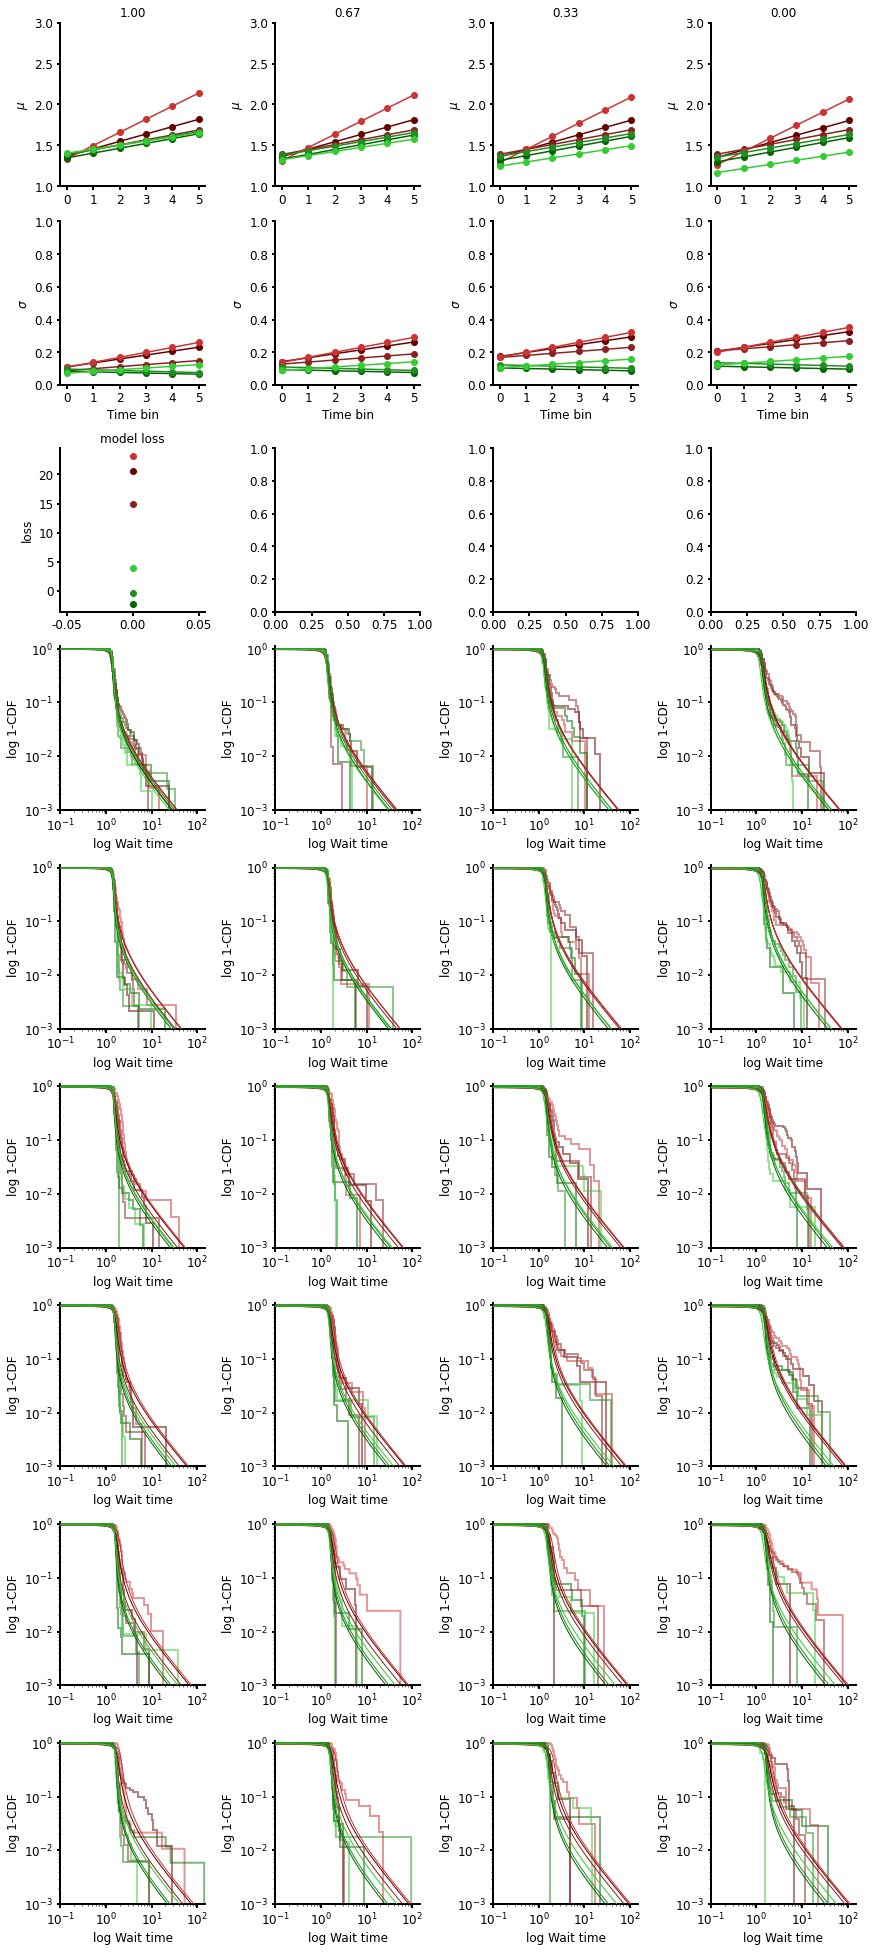

In [83]:
# ok
targetlist = generate_targetList(3)[::-1]
fig, axs = plt.subplots(9, len(meankeys(targetlist)), figsize=(12, 27))
exampledata = prepare_dataR(sequence, animalList, dist120)

mu = {}
sigma = {}
mu_prime = {}
sigma_prime = {}
mu_second = {}
sigma_second = {}
lossWald = {}
loc = {}

def plot_cauchy_fitted(waits, p, ax=None, color='k'):
    if ax is None: ax = plt.gca()
    waits = np.asarray(waits)

    bins=np.linspace(0, waits.max(), int(max(waits))*10)
    ydata, xdata, _ = ax.hist(waits, bins=bins,
                    color=color, alpha=.5, zorder=1, 
                    density=True, # weights=np.ones_like(waits) / len(waits),
                    histtype="step", lw=2, 
                    cumulative=-1,
                    )

    x = np.linspace(0.01, 500, 10000)
    # (mu, theta, sigma) = p
    loc, scale = p
    ax.plot(x, cauchy.sf(x, scale=scale, loc=loc), color=color, lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')

    # ax.plot(x, 1-Wald_cdf(x, mu, theta, sigma), color=color, lw=1, zorder=4, label=f'mean={sigma:.2f}, A={mu:.2f}, t0={theta:.2f}')

    ax.set_xlim(.1, 150)
    ax.set_ylim(.001, 1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel('log Wait time')
    ax.set_ylabel('log 1-CDF')

    return ax


for animal in animalList:

    (mu[animal], sigma[animal], 
        mu_prime[animal], sigma_prime[animal], 
        mu_second[animal], sigma_second[animal]), lossWald[animal] = modelrun_fit(exampledata[animal], 
                                                                                    # mu_t_fixed=False, 
                                                                                    # sigma_t_fixed=True, 
                                                                                    # mu_R_fixed=True, 
                                                                                    # sigma_R_fixed=True, 
                                                                                    )

    print(f"{animal}   a: {mu[animal]:.2f}, a': {mu_prime[animal]:.2f}, a'': {mu_second[animal]:.2f}, || g: {sigma[animal]:.2f}, g': {sigma_prime[animal]:.2f}, g'': {sigma_second[animal]:.2f},||| loss: {lossWald[animal]:.2f}")

    x = [0, 1, 2, 3, 4, 5]
    for i, avg in enumerate(meankeys(targetlist)):
        axs[0, i].plot(x, [mu[animal] + (bin*mu_prime[animal]) for bin in x] + i*mu_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
        axs[0, i].set_title(f"{avg:.2f}")
        axs[0, i].set_xticks(x)
        # axs[0, i].set_xlabel('Time bin')
        axs[0, i].set_ylabel(r'$\mu$')
        axs[0, i].set_ylim([1, 3])
        
        axs[1, i].plot(x, [sigma[animal] + (bin*sigma_prime[animal]) for bin in x] + i*sigma_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
        # axs[1, i].set_title(f"{avg:.2f}")
        axs[1, i].set_xticks(x)
        axs[1, i].set_xlabel('Time bin')
        axs[1, i].set_ylabel(r'$\sigma$')
        axs[1, i].set_ylim([0, 1])

    y = lossWald[animal]
    axs[2, 0].plot(0, y, color=rat_markers[animal][0], label=animal, marker='o')
    axs[2, 0].set_title(f"model loss")
    axs[2, 0].set_ylabel(r'loss')

    for j in range(6):
        for i, avg in enumerate(meankeys(targetlist)):
            plot_cauchy_fitted(exampledata[animal][j][i], (mu[animal] + j*mu_prime[animal] + i*mu_second[animal], sigma[animal] + j*sigma_prime[animal] + i*sigma_second[animal]), ax=axs[3+j, i], color=rat_markers[animal][0])


RatF00: (False, False, False, False), n_params=6, loss=32891.02613661639
RatF00: (False, False, False, True), n_params=5, loss=32941.20250510878
RatF00: (False, False, True, False), n_params=5, loss=32733.601306085708
RatF00: (False, False, True, True), n_params=4, loss=32785.12824175837
RatF00: (False, True, False, False), n_params=5, loss=33207.94078012622
RatF00: (False, True, False, True), n_params=4, loss=33212.91888029076
RatF00: (False, True, True, False), n_params=4, loss=33050.59225300033
RatF00: (False, True, True, True), n_params=3, loss=33057.39131333165
RatF00: (True, False, False, False), n_params=5, loss=40085.80445618346
RatF00: (True, False, False, True), n_params=4, loss=40040.55348649696
RatF00: (True, False, True, False), n_params=4, loss=39978.260497520554
RatF00: (True, False, True, True), n_params=3, loss=39973.77126596025
RatF00: (True, True, False, False), n_params=4, loss=40404.430945457
RatF00: (True, True, False, True), n_params=3, loss=40339.11134024204
Rat

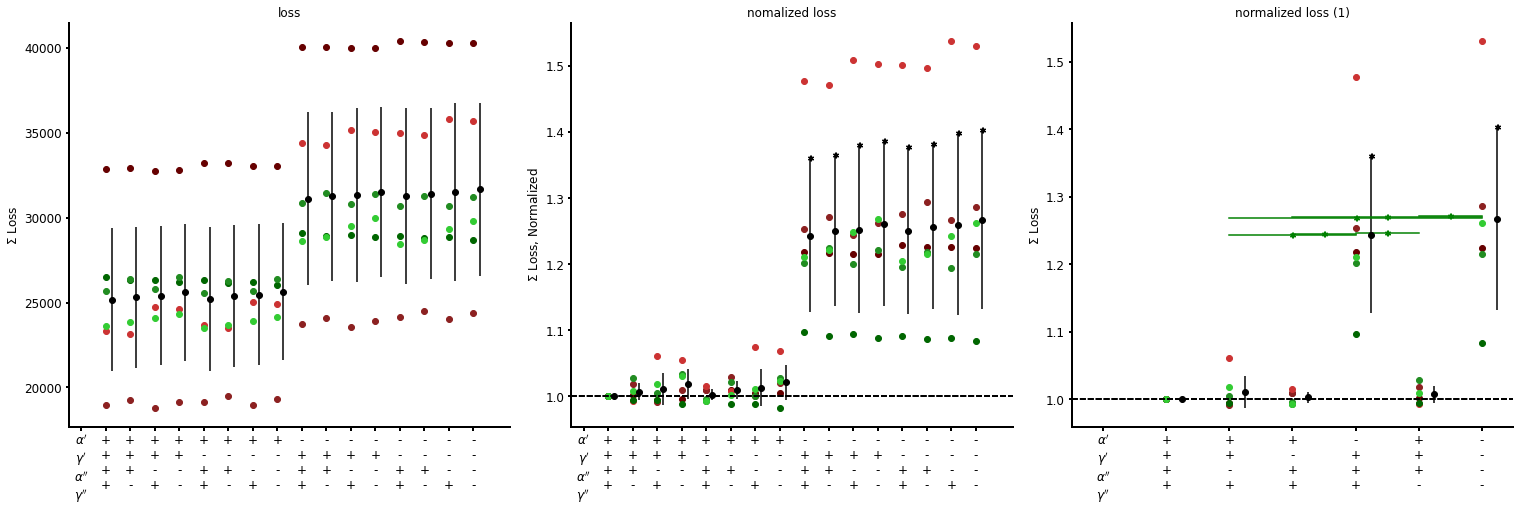

In [80]:
targetlist = generate_targetList(seq_len=4)[::-1]
fig, axs = plt.subplots(1, 3, figsize=(21, 7))


losses = {}
the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

the_keys_i_want = [(False, False, False, False), 
                    (False, False, True, False), 
                    (False, True, False, False), 
                    (True, False, False, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

for animal in animalList:
    losses[animal] = {}
    for mu_t_fixed in [False, True]:
        for sigma_t_fixed in [False, True]:
            for mu_R_fixed in [False, True]:
                for sigma_R_fixed in [False, True]:
                    number_of_params = 2  # mu, sigma
                    number_of_extra_params = mu_t_fixed+sigma_t_fixed+mu_R_fixed+sigma_R_fixed
                    loss = modelrun_fit(dataAll[animal],
                                        f=modelrun_compare,
                                        mu_t_fixed=mu_t_fixed, 
                                        sigma_t_fixed=sigma_t_fixed, 
                                        mu_R_fixed=mu_R_fixed, 
                                        sigma_R_fixed=sigma_R_fixed, 
                                        N_params=number_of_params + (4 - number_of_extra_params),
                                        )[1]

                    print(f'{animal}: {mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed}, n_params={number_of_params + (4 - number_of_extra_params)}, loss={loss}')

                    losses[animal][(mu_t_fixed, sigma_t_fixed, mu_R_fixed, sigma_R_fixed)] = loss

    axs[0].scatter(np.arange(16), losses[animal].values(), color=rat_markers[animal][0], label=animal)
    axs[0].set_title(f"loss")
    axs[0].set_ylabel(r'$\Sigma$ Loss')
    axs[0].set_xticks(np.arange(-1, 16))
    axs[0].set_xticklabels(dict_to_xticklabels(losses[animal]))
    # axs[0].set_ylim([80000, 140000])
    axs[0].set_xlim([-1.5, 16.5])

    axs[1].scatter(np.arange(16), list(losses[animal].values())/losses[animal][False, False, False, False], color=rat_markers[animal][0], label=animal)
    axs[1].set_title(f"nomalized loss")
    axs[1].set_ylabel(r'$\Sigma$ Loss, Normalized')
    axs[1].set_xticks(np.arange(-1, 16))
    axs[1].set_xticklabels(dict_to_xticklabels(losses[animal]))
    # axs[1].set_ylim([.975, 1.5])
    axs[1].set_xlim([-1.5, 16.5])
    axs[1].axhline(1, color='k', linestyle='--')

    for i, key in enumerate(the_keys_i_want):
        axs[2].scatter(i+1, losses[animal][key]/losses[animal][False, False, False, False], color=rat_markers[animal][0], label=animal)
    axs[2].set_title(f"normalized loss (1)")
    axs[2].set_ylabel(r'$\Sigma$ Loss')
    axs[2].set_xticks(np.arange(7))
    axs[2].set_xticklabels(dict_to_xticklabels({k:losses[animal][k] for k in the_keys_i_want}))
    # axs[2].set_ylim([.975, 1.5])
    axs[2].set_xlim([-.5, 6.5])
    axs[2].axhline(1, color='k', linestyle='--')

# average by key
means = [np.mean([losses[animal][key] for animal in animalList]) for key in losses[animal].keys()]
yerr = [np.std([losses[animal][key] for animal in animalList]) for key in losses[animal].keys()]
axs[0].errorbar(np.arange(16)+.25, means, yerr=yerr, color='k', label='Mean', marker='o', fmt=' ')

means_norm = [np.mean([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in losses[animal].keys()]
yerr_norm = [np.std([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in losses[animal].keys()]
axs[1].errorbar(np.arange(16)+.25, means_norm, yerr=yerr_norm, color='k', label='Mean', marker='o', fmt=' ')

means_norm_select = [np.mean([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in the_keys_i_want]
yerr_norm_select = [np.std([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in the_keys_i_want]
axs[2].errorbar(np.arange(len(the_keys_i_want))+1.25, means_norm_select, yerr=yerr_norm_select, color='k', label='Mean', marker='o', fmt=' ')


for idx, key in enumerate(losses[animal].keys()):
    data = [losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]
    s, p = stats.ttest_1samp(data, 1)
    if p < .05: axs[1].scatter(idx+.25, np.mean(data) + np.std(data) + 0.0025, color='k', marker=r'$\ast$')

print("all vs ++++: (1 sample t-tests)")
for idx, key in enumerate(the_keys_i_want):
    data = [losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]
    s, p = stats.ttest_1samp(data, 1)
    if p < .05: axs[2].scatter(idx+1.25, np.mean(data) + np.std(data) + 0.0025, color='k', marker=r'$\ast$')
    print(f"1 vs. {key}: {p:.3f} {'*' if p < .05 else ''}")
print()
print("comparisons: (2 sample t-tests)")
test_all_keys_between_themselves(losses, the_keys_i_want[1:], axs[2])



In [82]:
dataAll = prepare_dataR(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)


4.252525252525253


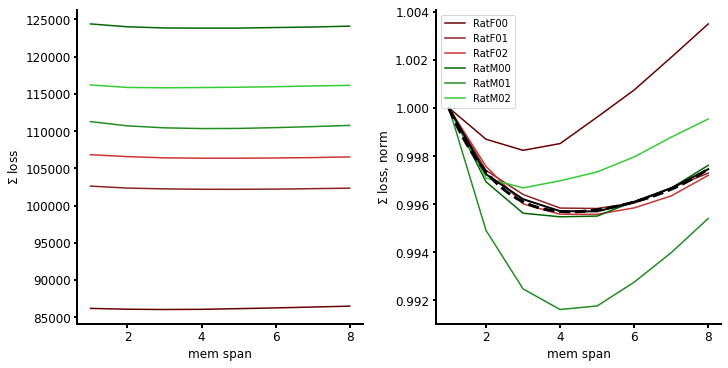

In [84]:
memsizes = np.arange(1, 9)

losses = {k:np.zeros(len(memsizes)) for k in animalList}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

for idx, memsize in enumerate(memsizes):
    data_all = prepare_data(sequence, animalList, sessions, memsize=memsize, time_bins=6)
    for animal in animalList:
        p, losses[animal][idx] = modelrun_fit(data_all[animal], f=modelrun_compare, N_bins=6, N_avg=len(meankeys(generate_targetList(seq_len=memsize)[::-1])))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
avglosses = np.zeros((len(animalList), len(memsizes)))
for idx, animal in enumerate(animalList):
    axs[0].plot(memsizes, losses[animal], color=rat_markers[animal][0])
    axs[1].plot(memsizes, (losses[animal])/(losses[animal][0]), color=rat_markers[animal][0], label=animal)
    avglosses[idx] = losses[animal]/losses[animal][0]

f = np.mean(avglosses[:3], axis=0)
m = np.mean(avglosses[3:], axis=0)
avglosses = np.median(avglosses, axis=0)

axs[1].plot(memsizes, avglosses, color='k', lw=2)
z = np.poly1d(np.polyfit(memsizes, avglosses, 4))
x=np.linspace(1, 8, 100)
axs[1].plot(x, z(x), color='k', lw=3, ls='--')
print(x[np.argmin(z(x))])
# axs[0].plot(memsizes, f/3, color='r', lw=2, ls='--')
# axs[0].plot(memsizes, m/3, color='g', lw=2, ls='--')
# axs[1].plot(memsizes, f, color='r', lw=2, ls='--')
# axs[1].plot(memsizes, m, color='g', lw=2, ls='--')

axs[0].set_xlabel('mem span')
axs[1].set_xlabel('mem span')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')
axs[1].legend()

